In [1]:
%matplotlib inline
import numpy as np
import torch
from torch.utils.serialization import load_lua
import os
import scipy.io as sio
import cv2
import math
from matplotlib import pyplot as plt

In [2]:
TRAIN_DATA_DIR = '/Data/nruiz9/data/facial_landmarks/300W_LP/'
AFW = os.path.join(TRAIN_DATA_DIR, 'AFW')

[  1.69706825e+06  -6.53330156e+04  -4.11682719e+05   4.34919781e+05
   2.50819281e+05   3.26359844e+04   1.24291895e+04  -2.52986391e+05
  -6.15043477e+04  -1.59830828e+05   2.63572094e+05   1.71440203e+05
  -4.88330117e+04  -1.97090562e+05   2.38590391e+04   4.10180391e+04
   1.01344531e+05   2.08940688e+05   1.22712875e+05  -2.61847754e+04
   5.90344609e+04  -1.15512295e+04  -4.96931484e+04   5.07356172e+04
   3.72444492e+04  -5.69681289e+04   6.74712188e+04  -4.20915156e+04
  -3.63388320e+04  -2.46653613e+04   2.91140586e+04  -3.11200098e+04
   1.61020850e+04  -2.50033203e+02  -4.18961016e+04  -4.14161211e+04
   6.62841797e+01   1.20681201e+04  -3.56137744e+03  -2.65995938e+04
   2.30893848e+03  -1.03691650e+03  -1.16494004e+04   2.12929688e+04
   1.52232812e+04   3.64335430e+04   1.74000312e+04   1.89377402e+04
  -1.34393281e+04   1.66427832e+04  -8.03712305e+03  -5.96380493e+02
   4.30957910e+03   2.24528638e+03   1.95483027e+04  -1.38550059e+04
  -1.93898594e+04  -3.69277188e+04

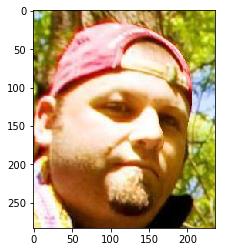

[270 316 613 659]
['roi', 'Shape_Para', 'Pose_Para', 'Exp_Para', '__header__', '__globals__', 'Color_Para', 'Illum_Para', 'pt2d', '__version__', 'Tex_Para']
pitch, yaw, roll:  3.42978 -26.1518 11.9776


In [23]:
img_name = 'AFW_2417212918_1_2'
img_path = os.path.join(AFW, img_name + '.jpg')
mat_path = os.path.join(AFW, img_name + '.mat')

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
mat = sio.loadmat(mat_path)

h, w, depth = img.shape
bbox = mat['roi'][0] - w/2
x_min = min(mat['pt2d'][0,:])
y_min = min(mat['pt2d'][1,:])
x_max = max(mat['pt2d'][0,:])
y_max = max(mat['pt2d'][1,:])

k = 0.15
x_min -= k * abs(x_max - x_min)
y_min -= 4 * k * abs(y_max - y_min)
x_max += k * abs(x_max - x_min)
y_max += 0.4 * k * abs(y_max - y_min)

cropped_img = img[int(y_min):int(y_max), int(x_min):int(x_max), :]

print mat['Shape_Para'][:,0]

plt.imshow(img)
plt.imshow(cropped_img)
plt.show()
print bbox
print mat.keys()
pitch, yaw, roll = mat['Pose_Para'][0][0:3] * 180 / np.pi
print 'pitch, yaw, roll: ', pitch, yaw, roll

[-0.87804114818573, -0.22214050590991974, -0.1486462503671646, 216.78628540039062, 242.63656616210938, -66.12765502929688, 0.0013571734307333827]
-0.878041 0.222141 -0.148646
((286.48701538719649, 128.29936640991286), (163.45533962552264, 258.61294564663456), (174.83399077116931, 280.22379053300978), 141.78628540039062, 167.63656616210938)


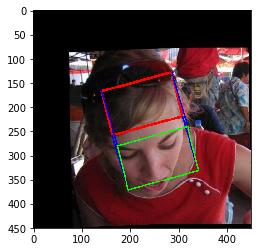

In [6]:
# For pose we have [pitch yaw roll tdx tdy tdz scale_factor]
from math import cos, sin

img_name = 'AFW_91328372_1_1'
img_path = os.path.join(AFW, img_name + '.jpg')
mat_path = os.path.join(AFW, img_name + '.mat')

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
mat = sio.loadmat(mat_path)

frame = img
pose_params = mat['Pose_Para'][0]

print pose_params.tolist()
pitch, yaw, roll, tdx, tdy, tdz, scale = pose_params

size = 150

p = pitch
y = -yaw
r = roll

if y < 0:
    face_x = tdx - 0.50 * size
    face_y = tdy - 0.50 * size
else:
    face_x = tdx - 0.50 * size
    face_y = tdy - 0.50 * size
    

print p, y ,r

x1 = size * (cos(y) * cos(r)) + face_x
y1 = size * (cos(p) * sin(r) + cos(r) * sin(p) * sin(y)) + face_y

x2 = size * (-cos(y) * sin(r)) + face_x
y2 = size * (cos(p) * cos(r) - sin(p) * sin(y) * sin(r)) + face_y

x3 = size * (sin(y)) + face_x
y3 = size * (-cos(y) * sin(p)) + face_y

print((x1, y1), (x2, y2), (x3, y3), face_x, face_y)
# Draw base in red
cv2.line(frame, (int(face_x), int(face_y)), (int(x1),int(y1)),(255,0,0),3)
cv2.line(frame, (int(face_x), int(face_y)), (int(x2),int(y2)),(255,0,0),3)
cv2.line(frame, (int(x2), int(y2)), (int(x2+x1-face_x),int(y2+y1-face_y)),(255,0,0),3)
cv2.line(frame, (int(x1), int(y1)), (int(x1+x2-face_x),int(y1+y2-face_y)),(255,0,0),3)
# Draw pillars in blue
cv2.line(frame, (int(face_x), int(face_y)), (int(x3),int(y3)),(0,0,255),2)
cv2.line(frame, (int(x1), int(y1)), (int(x1+x3-face_x),int(y1+y3-face_y)),(0,0,255),2)
cv2.line(frame, (int(x2), int(y2)), (int(x2+x3-face_x),int(y2+y3-face_y)),(0,0,255),2)
cv2.line(frame, (int(x2+x1-face_x),int(y2+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,0,255),2)
# Draw top in green
cv2.line(frame, (int(x3+x1-face_x),int(y3+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
cv2.line(frame, (int(x2+x3-face_x),int(y2+y3-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
cv2.line(frame, (int(x3), int(y3)), (int(x3+x1-face_x),int(y3+y1-face_y)),(0,255,0),2)
cv2.line(frame, (int(x3), int(y3)), (int(x3+x2-face_x),int(y3+y2-face_y)),(0,255,0),2)

plt.imshow(frame)
plt.show()